In [217]:
# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing

from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn import decomposition

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [218]:
import chardet
import os
cwd = os.getcwd()
cwd

'/Users/ricardo/Desktop/TFG/CODIGO'

In [219]:
landing = '/Users/ricardo/Desktop/TFG/CODIGO/TWEETS/'
df = pd.read_csv(landing + 'Tesla 2019-04-05 185519.csv', encoding='utf-8',#ISO-8859-1
                 names=['created_at', 'text', 'lang'])
df.head(3)

,created_at,text,lang
0,Fri Apr 05 16:55:17 +0000 2019,We’re coming for you Toyota,en
1,Fri Apr 05 16:55:18 +0000 2019,@Yeomen23 @TeslaCharts @SEC_Enforcement Basica...,en
2,Fri Apr 05 16:55:20 +0000 2019,@dodiewill2 @Manic_Marge @Kristennetten @Chris...,en


In [220]:
df['lang'].replace('en-gb','en')

0       en
1       en
2       en
3       en
4       en
5       en
6       en
7       en
8       en
9       en
10      en
11      en
12      en
13      en
14      en
15      en
16      en
17      en
18      en
19      en
20      en
21      en
22      en
23      en
24      en
25      en
26      en
27      en
28      en
29      en
        ..
9489    en
9490    en
9491    en
9492    en
9493    en
9494    en
9495    en
9496    en
9497    en
9498    en
9499    en
9500    en
9501    en
9502    en
9503    en
9504    en
9505    en
9506    en
9507    en
9508    en
9509    en
9510    en
9511    en
9512    en
9513    en
9514    en
9515    en
9516    en
9517    en
9518    en
Name: lang, Length: 9519, dtype: object

In [221]:
from datetime import datetime
for x in df['created_at']:
    d = datetime.strptime(x,'%a %b %d %H:%M:%S %z %Y')
    df['Date'] = d.date()

del df['created_at']

df = df[['Date', 'text', "lang"]]

df.head(3)




,Date,text,lang
0,2019-04-05,We’re coming for you Toyota,en
1,2019-04-05,@Yeomen23 @TeslaCharts @SEC_Enforcement Basica...,en
2,2019-04-05,@dodiewill2 @Manic_Marge @Kristennetten @Chris...,en


In [222]:
df['len'] = df['text'].str.len()

df.head(3)

,Date,text,lang,len
0,2019-04-05,We’re coming for you Toyota,en,27
1,2019-04-05,@Yeomen23 @TeslaCharts @SEC_Enforcement Basica...,en,140
2,2019-04-05,@dodiewill2 @Manic_Marge @Kristennetten @Chris...,en,134


## Data Cleaning

Data cleaning process is similar to my previous project, but this time I added a long list of contraction to expand most of the contracted form to its original form such as "don't" to "do not". And this time, instead of Regex, I used Spacy to parse the documents, and filtered numbers, URL, punctuation, etc. Below are the steps I took to clean the tweets.

&nbsp;&nbsp;&nbsp;1.Decoding: unicode_escape for extra "\" before unicode character, then unidecode <br>
&nbsp;&nbsp;&nbsp;2.Apostrophe handled: there are two characters people use for contraction. "’"(apostrophe) and "'"(single quote). If these two symbols are both used for contraction, it will be difficult to detect and properly map the right expanded form. So any "’"(apostrophe) is changed to "'"(single quote)<br>
&nbsp;&nbsp;&nbsp;3.Contraction check: check if there's any contracted form, and replace it with its original form <br>
&nbsp;&nbsp;&nbsp;4.Parsing: done with Spacy<br>
&nbsp;&nbsp;&nbsp;5.Filtering punctuation, white space, numbers, URL using Spacy methods while keeping the text content of hashtag intact
&nbsp;&nbsp;&nbsp;6.Removed @mention<br>
&nbsp;&nbsp;&nbsp;7.Lemmatize: lemmatized each token using Spacy method '.lemma_'. Pronouns are kept as they are since Spacy lemmatizer transforms every pronoun to "-PRON-" <br>
&nbsp;&nbsp;&nbsp;8.Special character removal<br>
&nbsp;&nbsp;&nbsp;9.Single syllable token removal<br>
&nbsp;&nbsp;&nbsp;10.Spell correction: it is a simple spell correction dealing with repeated characters such as "sooooo goooood". If the same character is repeated more than two times, it shortens the repetition to two. For example "sooooo goooood" will be transformed as "soo good". This is not a perfect solution since even after correction, in case of "soo", it is not a correct spelling. But at least it will help to reduce feature space by making "sooo", "soooo", "sooooo" to the same word "soo"

In [223]:
#https://github.com/tthustla/yet_another_tiwtter_sentiment_analysis_part1/blob/master
#/Yet_Another_Twitter_Sentiment_Analysis_part1-Copy1.ipynb

In [224]:
negations_dic = {"RT":"", "rt": "","lmao":"laughing my ass off","wtf":"what the fuck","I":"","and":"","to":"",
                 "you":"", "he":"", "she":"", "it":"","we":"","lol":"laughing out loud",
                   "on":"","that":"", "at":"", "for":"", "us":"", "our":"","in":"",
                   "mine":"","your":"","them":"","his":"","her":"","myself":"","yourserlf":"",
                   "hisself":"", "yours":"", "ours":"", "their":"", "those":"", "this":"",
                   "ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "ll":"will",
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is", "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have",
                   "oh damn":"incredible","whatcha":"what are you","luv":"love","sux":"sucks","btw":"by the way"}          


SMILEY = {":‑)":"smiley",":-]":"smiley",":-3":"smiley",":->":"smiley","8-)":"smiley",":-}":"smiley",
        ":)":"smiley",":]":"smiley",":3":"smiley",":>":"smiley","8)":"smiley",":}":"smiley",
         ":o)":"smiley",":c)":"smiley",":^)":"smiley","=]":"smiley","=)":"smiley",":-))":"smiley",
         ":‑D":"smiley", "8‑D":"smiley","x‑D":"smiley", "X‑D":"smiley",":D":"smiley","8D":"smiley",
         "xD":"smiley","XD":"smiley",":‑(":"sad", ":‑c":"sad", ":‑<":"sad",":‑[":"sad",    
         ":(":"sad",":c":"sad",":<":"sad",":[":"sad", ":-||":"sad",">:[":"sad",":{":"sad",
         ":@":"sad",">:(":"sad",":‑(":"sad",":(":"sad",":‑P":"playful","X‑P":"playful",
         "x‑p":"playful", ":‑p":"playful", ":‑Þ":"playful", ":‑þ":"playful",":‑b":"playful",
         ":P":"playful","XP":"playful", "xp":"playful",":p":"playful", ":Þ":"playful",":þ":"playful", 
         "ð¢":"cry",":b":"playful","<3":"love"}
                   


The first issue is that, during the cleaning process, negation words are split into two parts, and the 't' after the apostrophe vanishes when I filter tokens with length more than one syllable. This makes words like "can't" end up as same as "can". This seems like not a trivial matter for sentiment analysis purpose.

The second issue is that some of the URL links don't start with "http", sometimes people paste a link in "www.aaaa.com" form. This wasn't properly handled when I defined the URL address pattern as 'https?://[A-Za-z0-9./]+'. And another problem with this regex pattern is that it only detects alphabet, number, period, slash. This means it will fail to catch the part of the URL if it contains any other special character such as "=", "_", "~", etc.</n>

The third issue is the regex pattern for Twitter ID. In the previous cleaning function I defined it as '@[A-Za-z0-9]+', but with a little googling, I found out that twitter ID also allows underscore symbol as a character can be used with ID. Except for underscore symbol, only characters allowed are alphabets and numbers.

In [225]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
from bs4 import BeautifulSoup

In [226]:
import re
import emoji
import itertools
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import Word 

corpus = []
ps = PorterStemmer()
sb_stemmer = SnowballStemmer("english",)
tok = WordPunctTokenizer()
wnl = WordNetLemmatizer()

def tweet_cleaner(text):

    pat1 = r'(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)'
    pat2 = r'https?://[^ ]+'
    combined_pat = r'|'.join((pat1, pat2))
    www_pat = r'www.[^ ]+'
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
    ps = PorterStemmer()
    tok = WordPunctTokenizer()
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped

    tweet_1 = emoji.demojize(bom_removed)    
        
    stripped = re.sub(combined_pat, '', tweet_1)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    
    # Standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(neg_handled))
    
    #Deal with emojis  

    words_1 = tweet.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words_1]
    tweet = " ".join(reformed)
    
    letters_only = re.sub("[^a-zA-Z]", " ", tweet)
    words = [x for x in nltk.word_tokenize(letters_only) if len(x) > 1]
    
    #review = [sb_stemmer.stem(word) for word in words]
    review_2 = [wnl.lemmatize(word) for word in words]
    return (' '.join(review_2)).strip()

# DO NOT REMOVE STOP WORDS FOR SENTIMENT ANALYSIS - OR AT LEAST NOT NEGATIVE ONES

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ricardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [227]:
df = df.dropna(subset=['text'])

In [228]:
df['text_clean'] = [tweet_cleaner(t) for t in df['text']]


In [229]:
df['text_clean'].head(10)

0                                     re coming toyota
1    enforcement basically robinhood is the crowdfu...
2                                       marge jeffreyr
3        change screen preference from night mode auto
4        stay tuned the live streaming pick the winner
5    what have done team no confirmation noa seems ...
6    fun drive mountain with great control regenera...
7    exclusive united state set sight china new ele...
8           literally baby who have been the planet mo
9    my imaginary tesla after hitting the supercharger
Name: text_clean, dtype: object

LIMPIEZA DE OUTLIERS --> LOS REULSTADOS NO VARÍAN CASI NADA
ESTO ESTA INTERESANTE

#Previously, we just removed commonly occurring words in a general sense. 
#We can also remove commonly occurring words from our text data First, 
#let’s check the 10 most frequently occurring words in our text data then
#take call to remove or retain.

freq = pd.Series(' '.join(df['text_clean']).split()).value_counts()[:5]
print(freq)

print(30*"--")

freq = list(freq.index)
df['text_clean'] = df['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text_clean'].head()



#Eliminate the uncommon noums that are mentioned and which do not give us any info
freq = pd.Series(' '.join(df['text_clean']).split()).value_counts()[-100:]
freq = list(freq.index)
df['text_clean'] = df['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text_clean'].head()

## Sentiment Analysis
http://textblob.readthedocs.io/en/dev/

In [230]:
from textblob import TextBlob
import re


Utility function to classify the polarity of a tweet using textblob.
   

In [231]:

def analize_sentiment_English(tweet):
    
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1


In [232]:
df['SA'] = np.array([ analize_sentiment_English(tweet) for tweet in df['text_clean'] ])
display(df.head(20))

,Date,text,lang,len,text_clean,SA
0,2019-04-05,We’re coming for you Toyota,en,27,re coming toyota,0
1,2019-04-05,@Yeomen23 @TeslaCharts @SEC_Enforcement Basica...,en,140,enforcement basically robinhood is the crowdfu...,1
2,2019-04-05,@dodiewill2 @Manic_Marge @Kristennetten @Chris...,en,134,marge jeffreyr,0
3,2019-04-05,RT @elonmusk: @SherylCrow @Tesla Change your s...,en,86,change screen preference from night mode auto,0
4,2019-04-05,RT @justinsuntron: Stay tuned for the live str...,en,124,stay tuned the live streaming pick the winner,1
5,2019-04-05,"RT @M3Exp: What have you DONE, ⁦@Tesla⁩ team a...",en,140,what have done team no confirmation noa seems ...,0
6,2019-04-05,RT @tarunemany: Fun to drive in mountains with...,en,140,fun drive mountain with great control regenera...,1
7,2019-04-05,Exclusive: United States sets sights on China ...,en,111,exclusive united state set sight china new ele...,1
8,2019-04-05,@DickWinchester @Sublux8tor @kulpability @alex...,en,140,literally baby who have been the planet mo,0
9,2019-04-05,my imaginary Tesla after hitting the supercharger,en,49,my imaginary tesla after hitting the supercharger,0


In [233]:
# We construct lists with classified tweets:
pos_tweets = [ tweet for index, tweet in enumerate(df['text_clean']) if df['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(df['text_clean']) if df['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(df['text_clean']) if df['SA'][index] < 0]

# We print percentages:
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['text_clean'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['text_clean'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(df['text_clean'])))

Percentage of positive tweets: 39.00619813005568%
Percentage of neutral tweets: 42.66204433238786%
Percentage de negative tweets: 18.331757537556467%


In [234]:
print("{0:.2f}%".format(df["SA"].mean() *100))
len(df.SA)

20.67%


9519

In [235]:
df['SA'] = np.array([ analize_sentiment_English(tweet)
                     for tweet in df['text_clean'] ])
display(df.head(10))

,Date,text,lang,len,text_clean,SA
0,2019-04-05,We’re coming for you Toyota,en,27,re coming toyota,0
1,2019-04-05,@Yeomen23 @TeslaCharts @SEC_Enforcement Basica...,en,140,enforcement basically robinhood is the crowdfu...,1
2,2019-04-05,@dodiewill2 @Manic_Marge @Kristennetten @Chris...,en,134,marge jeffreyr,0
3,2019-04-05,RT @elonmusk: @SherylCrow @Tesla Change your s...,en,86,change screen preference from night mode auto,0
4,2019-04-05,RT @justinsuntron: Stay tuned for the live str...,en,124,stay tuned the live streaming pick the winner,1
5,2019-04-05,"RT @M3Exp: What have you DONE, ⁦@Tesla⁩ team a...",en,140,what have done team no confirmation noa seems ...,0
6,2019-04-05,RT @tarunemany: Fun to drive in mountains with...,en,140,fun drive mountain with great control regenera...,1
7,2019-04-05,Exclusive: United States sets sights on China ...,en,111,exclusive united state set sight china new ele...,1
8,2019-04-05,@DickWinchester @Sublux8tor @kulpability @alex...,en,140,literally baby who have been the planet mo,0
9,2019-04-05,my imaginary Tesla after hitting the supercharger,en,49,my imaginary tesla after hitting the supercharger,0


# SECOND ANALYSIS: GETTING RID OF THE NEUTRAL TWEETS

Create a new data frame in which w eget rid from the sentiment anañysis which value is = equal 0 or neutral in order to leave only the positive and negative sentiment tweets. 

In [236]:
def analize_sentiment_English(tweet):
    
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return -1
    else:
        return 0
    
data = df    
del data["SA"]    



Get a knowledge on how the tweets are psotive or negative in term of the total and then, we just can start using the new data frame to test the new results. 

In [237]:
data['SA'] = np.array([ analize_sentiment_English(tweet) for tweet in data['text_clean'] ])  

data = data[data.SA!= -1]

display(data.head(15))

,Date,text,lang,len,text_clean,SA
1,2019-04-05,@Yeomen23 @TeslaCharts @SEC_Enforcement Basica...,en,140,enforcement basically robinhood is the crowdfu...,1
4,2019-04-05,RT @justinsuntron: Stay tuned for the live str...,en,124,stay tuned the live streaming pick the winner,1
6,2019-04-05,RT @tarunemany: Fun to drive in mountains with...,en,140,fun drive mountain with great control regenera...,1
7,2019-04-05,Exclusive: United States sets sights on China ...,en,111,exclusive united state set sight china new ele...,1
11,2019-04-05,RT @elonmusk: “…drivers in this dataset use Au...,en,139,driver dataset use autopilot of driven mile ye...,1
13,2019-04-05,@markbspiegel Have been saying this for years....,en,140,have been saying year tsla is first very forem...,1
14,2019-04-05,@dpolner @scottwillpenn @Trumpery45 @LivingTes...,en,139,drinking don but drink the toilet boy,0
15,2019-04-05,"RT @lloydalter: Tesla adds 2 new video games, ...",en,140,tesla add new video game super breakout it big...,1
16,2019-04-05,"Satisfying read, Shorty fools",en,29,satisfying read shorty fool,1
17,2019-04-05,RT @CNET: Tesla adds more Atari games to its d...,en,103,tesla add more atari game it dashboard joystick,1


In [238]:
print("""Siendo 0 el extremo negativo y 1 el positivo, hoy tenemos
que el sentimiento en los tweets sobre TSLA es de: {0:.2f} %""".format(data["SA"].mean() * 100))

#data.to_csv('example.csv')

Siendo 0 el extremo negativo y 1 el positivo, hoy tenemos
que el sentimiento en los tweets sobre TSLA es de: 68.03 %


In [239]:

print("Number of negative Tweets {0} and positive Tweets {1} :")
x = pd.value_counts(data['SA'].values, sort=False)
print (x)

print(30*"__")
print("\n")

print("Percentage of positive tweets: {0:.2f}%".format(len(pos_tweets)*100/len(data['text_clean'])))
print("Percentage de negative tweets: {0:.2f}%".format(len(neg_tweets)*100/len(data['text_clean'])))

Number of negative Tweets {0} and positive Tweets {1} :
0    1745
1    3713
dtype: int64
____________________________________________________________


Percentage of positive tweets: 68.03%
Percentage de negative tweets: 31.97%


In [240]:
import watermark
import fix_yahoo_finance

%load_ext watermark
%watermark -p pandas,numpy,datetime,matplotlib,pandas_datareader,fix_yahoo_finance

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
tsla = pdr.get_data_yahoo('TSLA', 
                          start=datetime.datetime(2019,3 , 26), 
                          end=datetime.datetime(2019, 4, 5))
tsla.head(10)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
pandas 0.23.4
numpy 1.14.2
datetime unknown
matplotlib 3.0.2
pandas_datareader 0.7.0
fix_yahoo_finance 0.0.22


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-26,270.260010,264.429993,264.440002,267.769989,7350900,267.769989
2019-03-27,275.369995,268.179993,268.750000,274.829987,8779200,274.829987
2019-03-28,280.329987,275.100006,277.160004,278.619995,6774100,278.619995
2019-03-29,280.160004,274.500000,278.700012,279.859985,5991300,279.859985
2019-04-01,289.200012,281.279999,282.619995,289.179993,8110400,289.179993
2019-04-02,289.440002,283.880005,288.299988,285.880005,5478900,285.880005
2019-04-03,296.170013,287.170013,287.320007,291.809998,7929900,291.809998
2019-04-04,271.200012,260.589996,261.890015,267.779999,23699500,267.779999
2019-04-05,276.100006,266.114990,269.859985,274.959991,13032026,274.959991


In [46]:
del tsla["High"]
del tsla["Low"]
del tsla["Open"]
del tsla["Volume"]
del tsla["Close"]



In [47]:
tsla.rename(columns={'Adj Close': 'Clossing Price'}, inplace=True)
tsla.head()

,Clossing Price
Date,
2019-03-26,267.769989
2019-03-27,274.829987
2019-03-28,278.619995
2019-03-29,279.859985


In [51]:
cont = 0

for x in tsla["Clossing Price"]: 
    y = ("P{0}".format(cont))
    tsla["Closing Price"][cont] = y 
    cont = cont + 1
    
tsla["SA"] = "[0,1]"
tsla["Result"] = "✅ or ❌"


del tsla["Clossing Price"]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [52]:
tsla.head(3)

,Closing Price,SA,Result
Date,,,
2019-03-26,P0,"[0,1]",✅ or ❌
2019-03-27,P1,"[0,1]",✅ or ❌
2019-03-28,P2,"[0,1]",✅ or ❌


# Train Test Split
Noticed that our classes are imbalanced, and the ratio of negative to positive instances is 30:70.
One of the tactics of combating imbalanced classes is using Decision Tree algorithms, so, we are using Random Forest classifier to learn imbalanced data and set class_weight=balanced.# 

In [567]:
from sklearn.model_selection import train_test_split
X = data.text
y = data.SA
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                        (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,30001,5001)
def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))



from sklearn.metrics import classification_report
cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['negative','positive']))

Train set has total 1089 entries with 25.44% negative, 74.56% positive
Test set has total 363 entries with 24.52% negative, 75.48% positive
Result for trigram with stop words (Tfidf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


Test result for 10000 features


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy score: 83.20%
Test result for 15001 features
accuracy score: 84.02%
Test result for 20002 features
accuracy score: 84.85%
Test result for 25003 features
accuracy score: 85.95%
              precision    recall  f1-score   support

    negative       0.97      0.44      0.60        89
    positive       0.85      1.00      0.91       274

   micro avg       0.86      0.86      0.86       363
   macro avg       0.91      0.72      0.76       363
weighted avg       0.88      0.86      0.84       363



# ML | Chi-square Test for feature selection

Feature selection is also known as attribute selection is a process of extracting the most relevant features from the dataset and then applying machine learning algorithms for the better performance of the model. A large number of irrelevant features increases the training time exponentially and increase the risk of overfitting.

Chi-square Test for Feature Extraction: 
Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with best Chi-square scores. It determines if the association between two categorical variables of the sample would reflect their real association in the population.
Chi- square score is given by (PHOTO) :
https://cdncontribute.geeksforgeeks.org/wp-content/uploads/Capture-214.png![image.png](attachment:image.png)

We will calculate the Chi square scores for all the features and visualize the top 20, here terms or words or N-grams are features, and positive and negative are two classes. given a feature X, we can use Chi square test to evaluate its importance to distinguish the class.

1ST:

To classify sentiment, we remove neutral score 0, then group score -1 and 1 to positive (TRUE), and score -1 to negative (FALSE). After simple cleaning up, this is the data we are going to work with.

If you consider how chi2 is calculated, it will not only score highly on terms predictive of positive class but also score highly on terms predictive of negative class.


In [345]:
#df.dropna(inplace=True)
#df[df['SA'] != 0]
#df['SA'] = np.logical_or(df['SA'] > 0,df['SA']<0)
#cols = ['SA']
#df.drop(cols, axis=1, inplace=True)
#df.head()

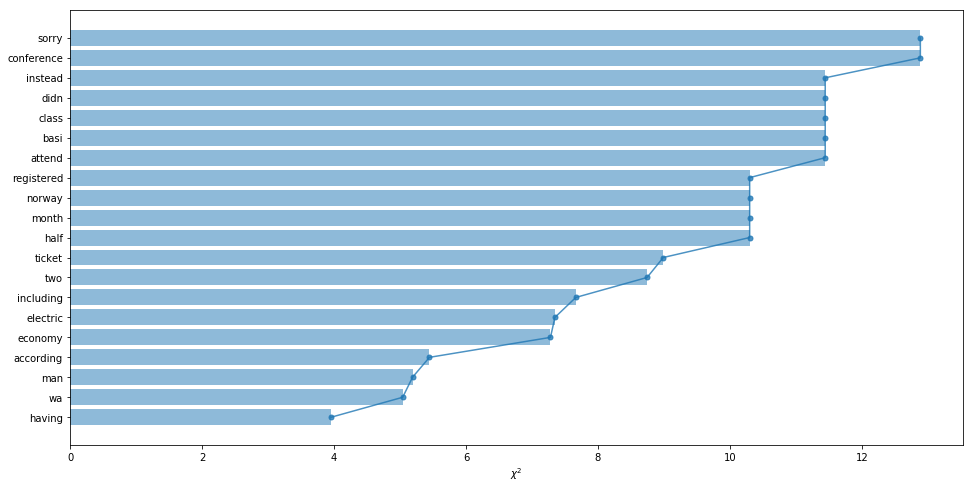

In [350]:
from sklearn.feature_selection import chi2
tfidf = TfidfVectorizer(max_features=100000,ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(df.text_clean)
y = df.SA
chi2score = chi2(X_tfidf, y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

# LSTM Framework

Pad sequences:

In order to feed this data into our RNN, all input documents must have the same length. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews with a null value (0). We can accomplish this using the pad_sequences() function in Keras. For now, set max_words Then, I define the number of max features as 30000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.


import os
os.environ['KERAS_BACKEND'] = 'tensorflow'


In [304]:

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re



Using TensorFlow backend.


In [ ]:
max_fatures = 30000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data["text_clean"].values)
X1 = tokenizer.texts_to_sequences(data["text_clean"].values)
X1 = pad_sequences(X1)
Y1 = pd.get_dummies(data["SA"]).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

#SUM OF BOTH is the total number of tweets

(2214, 34) (2214, 2)
(739, 34) (739, 2)


/anaconda3/lib/python3.6/site-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


# Recurrent neural network 


Remember that our input is a sequence of words (technically, integer word IDs) of maximum length = max_words, and our output is a binary sentiment label (0 or 1).


Keras offers an Embedding layer that can be used for neural networks on text data.
It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

It is a flexible layer that can be used in a variety of ways, such as:
It can be used alone to learn a word embedding that can be saved and used in another model later.

It can be used as part of a deep learning model where the embedding is learned along with the model itself.

It can be used to load a pre-trained word embedding model, a type of transfer learning.

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0–10, then the size of the vocabulary would be 11 words.

output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.

input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

For example, below we define an Embedding layer with a vocabulary of 200 (e.g. integer encoded words from 0 to 199, inclusive), a vector space of 32 dimensions in which words will be embedded, and input documents that have 50 words each.

e = Embedding(200, 32, input_length=50)

The Embedding layer has weights that are learned. If you save your model to file, this will include weights for the Embedding layer.The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words (input document).
If you wish to connect a Dense layer directly to an Embedding layer, you must first flatten the 2D output matrix to a 1D vector using the Flatten layer.

In [ ]:
embed_dim = 150
lstm_out = 200

In [ ]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 150)           4500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 4,781,202
Trainable params: 4,781,202
Non-trainable params: 0
_________________________________________________________________
None


# Train and evaluate our model 

We first need to compile our model by specifying the loss function and optimizer we want to use while training, as well as any evaluation metrics we’d like to measure. Specify the appropriate parameters, including at least one metric ‘accuracy’.

Once compiled, we can kick off the training process. There are two important training parameters that we have to specify — batch size and number of training epochs, which together with our model architecture determine the total training time.

Finally measuring the number of correct guesses. It is clear that finding negative tweets goes very well for the Network but deciding whether is positive is not really.

In [ ]:
batch_size = 32
model.fit(X1_train, Y1_train, nb_epoch = 3, batch_size=batch_size, verbose = 2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/3


In [ ]:
score,acc = model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))


In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X1_test)):
    
    result = model.predict(X1_test[x].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y1_test[x]):
        if np.argmax(Y1_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y1_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")
